<a href="https://colab.research.google.com/github/TimurMMD/transaction_project/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackaton HR Analytics.
Link: [HR Analytics](https://datahack.analyticsvidhya.com/contest/wns-analytics-hackathon-2018-1/#About)

##THe objective of the Project is to identify of the eligible candidates for promotion according to several metrics, such as: KPI, previous year's rating, training scores and etc.

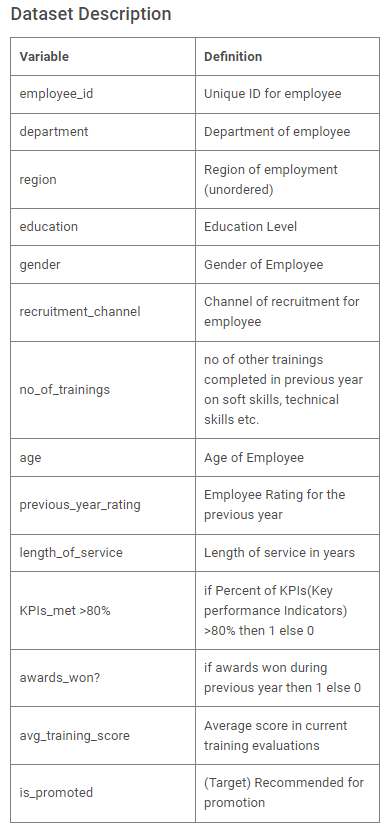

## 1. Libraries instantiation

In [2]:
!pip install catboost

In [119]:
# Libraries for visualisation and data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from collections import Counter
from sklearn.decomposition import PCA

# ML models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

##2. Uploading the data

In [78]:
# Concentrate all attention on training data first, and the same necessary steps would be repeated for the test data as well
data = pd.read_csv("/content/train_LZdllcl.csv")
test = pd.read_csv("/content/test_2umaH9m.csv")

##3. Data Exploration and Cleaning

In [79]:
# Check the dataset
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [80]:
# Check the columns of the dataset
columns = data.columns
print("Columns of the dataset:\n", columns)

Columns of the dataset:
 Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')


In [81]:
# The target column is a "is_promoted" and now we need to explore, check and prepare data before applying any of the ML algorithms
data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [82]:
data.duplicated().sum()

0

No duplicated values, that's good news!

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


We have some missimg value, let's calculate exactly

In [84]:
# Make the sum of missing values
data.isnull().sum()

,0
employee_id,0
department,0
region,0
education,2409
gender,0
recruitment_channel,0
no_of_trainings,0
age,0
previous_year_rating,4124
length_of_service,0


It's a 2400 for education column and 4100 for previous year rating. Now we need to understand why exactly this data is missing and how valuable it is.
I suppose, that for Education it could be number of people wothout any Education, which could be filled with None, but it need to be checked.
Tha same situation with the year rating, it simply could be employees that came last year and don't have any rating yet, consequntly thier rating could be 0, because without this characteristic their chances for promotion should be lower.

In [85]:
bool_series_year_rating = pd.isnull(data['previous_year_rating'])
data[bool_series_year_rating]['length_of_service'].value_counts()

,count
length_of_service,
1,4124


So, the theory of the freshmen in the company as the reason why they don't have rating score was absolutely right. We can fill this data with 0.

In [86]:
data['previous_year_rating'] = data['previous_year_rating'].fillna(0)

In [87]:
bool_series_education = pd.isnull(data['education'])
data[bool_series_education]
# There is no obvious patterns right now, so fill the missing data with "None" and will analyze further
data['education'] = data['education'].fillna('None')

In [88]:
# Check for missing values again
data.isnull().sum()

,0
employee_id,0
department,0
region,0
education,0
gender,0
recruitment_channel,0
no_of_trainings,0
age,0
previous_year_rating,0
length_of_service,0


Perfect! Let's explore data a bit more and make some charts, as a visualisation analysis is easier!

In [89]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


Distribution of the promotion in the dataset
is_promoted
0    0.91483
1    0.08517
Name: proportion, dtype: float64


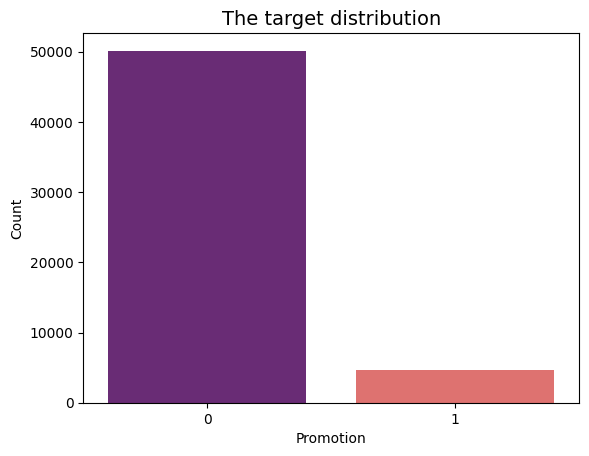

In [90]:
# Check the balance of the data
print('Distribution of the promotion in the dataset')
print(data['is_promoted'].value_counts(normalize=True))
sns.countplot(data=data, x='is_promoted', palette='magma', legend=False)
plt.xlabel('Promotion')
plt.ylabel('Count')
plt.title('The target distribution', fontsize=14)
plt.show()

The data is imbalanced and it's very importnatn to keep in mind in order to make the right evaluation of the model


### The next charts will be distributions all over the data to check how the connected/not connected with the promotion

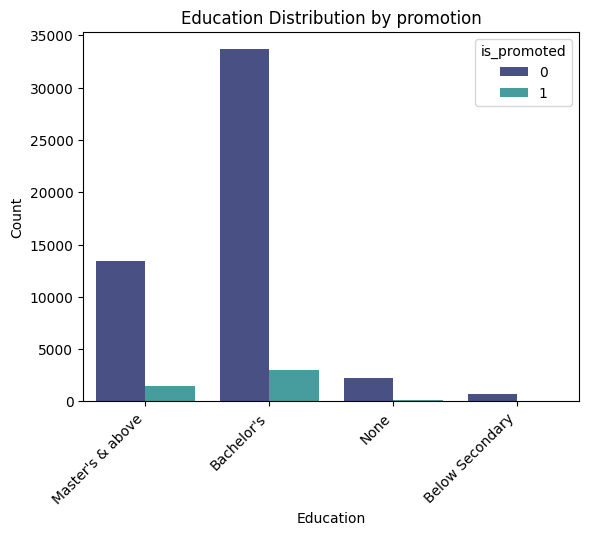

In [91]:
# Check the education connection
sns.countplot(data=data, x='education', hue='is_promoted', palette='mako')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability if needed
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Education Distribution by promotion')
plt.show()

In [92]:
education_data_kpi = data.groupby('education')['KPIs_met >80%'].value_counts(normalize=True).unstack()
education_data_prom = data.groupby('education')['is_promoted'].value_counts(normalize=True).unstack()
print("-------Distribution of KPI by Education-------------\n")
print(education_data_kpi)
print("----------------------------------------------------\n")
print("-------Distribution of Promotion by Education-------\n")
print(education_data_prom)
print("----------------------------------------------------\n")

-------Distribution of KPI by Education-------------

KPIs_met >80%            0         1
education                           
Bachelor's        0.645504  0.354496
Below Secondary   0.600000  0.400000
Master's & above  0.639866  0.360134
None              0.753010  0.246990
----------------------------------------------------

-------Distribution of Promotion by Education-------

is_promoted              0         1
education                           
Bachelor's        0.917969  0.082031
Below Secondary   0.916770  0.083230
Master's & above  0.901441  0.098559
None              0.949357  0.050643
----------------------------------------------------



There is a slight connection between education and chances to be promoted. But as we can the secondary parameter (KPI) has a high dependence on the education as employees without one have a lower metrics.

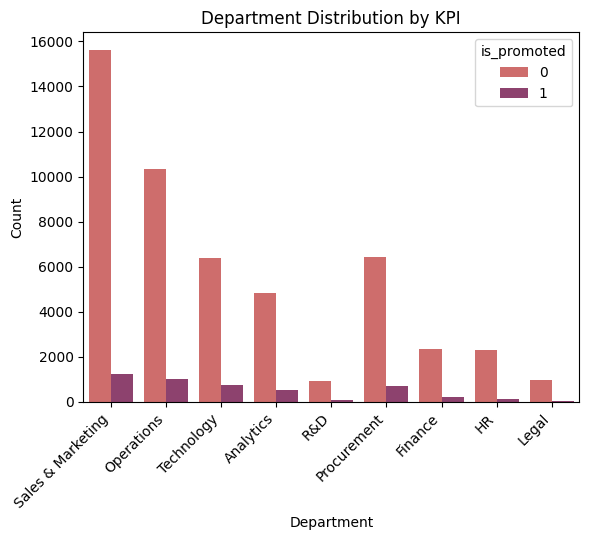

In [93]:
# Check the connection of the department
sns.countplot(data=data, x='department', hue='is_promoted', palette='flare')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability if needed
plt.xlabel('Department')
plt.ylabel('Count')
plt.title('Department Distribution by KPI')
plt.show()

In [94]:
department_data_prom_norm = data.groupby('department')['is_promoted'].value_counts(normalize=True).unstack()
department_data_prom = data.groupby('department')['is_promoted'].value_counts().unstack()
print("-------Distribution of Prommotion by Department------------\n")
print(department_data_prom)
print("----------------------------------------------------\n")
print("-------Distribution of Promotion by Department (NORMALIZED)------\n")
print(department_data_prom_norm)
print("----------------------------------------------------\n")

-------Distribution of Prommotion by Department------------

is_promoted            0     1
department                    
Analytics           4840   512
Finance             2330   206
HR                  2282   136
Legal                986    53
Operations         10325  1023
Procurement         6450   688
R&D                  930    69
Sales & Marketing  15627  1213
Technology          6370   768
----------------------------------------------------

-------Distribution of Promotion by Department (NORMALIZED)------

is_promoted               0         1
department                           
Analytics          0.904335  0.095665
Finance            0.918770  0.081230
HR                 0.943755  0.056245
Legal              0.948989  0.051011
Operations         0.909852  0.090148
Procurement        0.903614  0.096386
R&D                0.930931  0.069069
Sales & Marketing  0.927969  0.072031
Technology         0.892407  0.107593
----------------------------------------------------



It's hard to highlight any connection between the department and the promotion as the bigger percentage in average has the department with more workers.

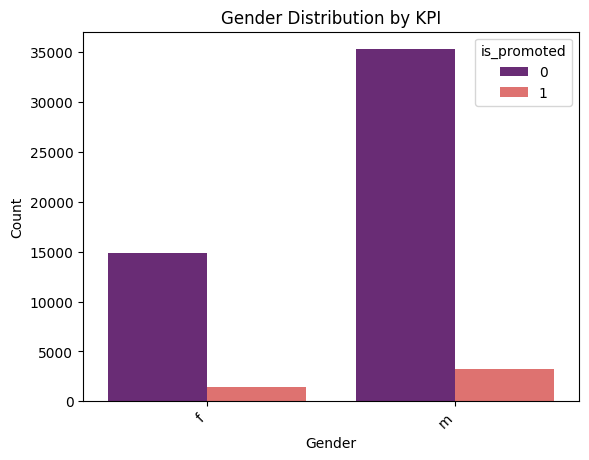

In [95]:
sns.countplot(data=data, x='gender', hue='is_promoted', palette='magma')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability if needed
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution by KPI')
plt.show()

In [96]:
gender_data_prom = data.groupby('gender')['is_promoted'].value_counts(normalize=True).unstack()
print("-------Distribution of Promotion by Gender------------\n")
print(gender_data_prom)
print("------------------------------------------------------\n")

-------Distribution of Promotion by Gender------------

is_promoted         0         1
gender                         
f            0.910066  0.089934
m            0.916849  0.083151
------------------------------------------------------



No gender correlations.

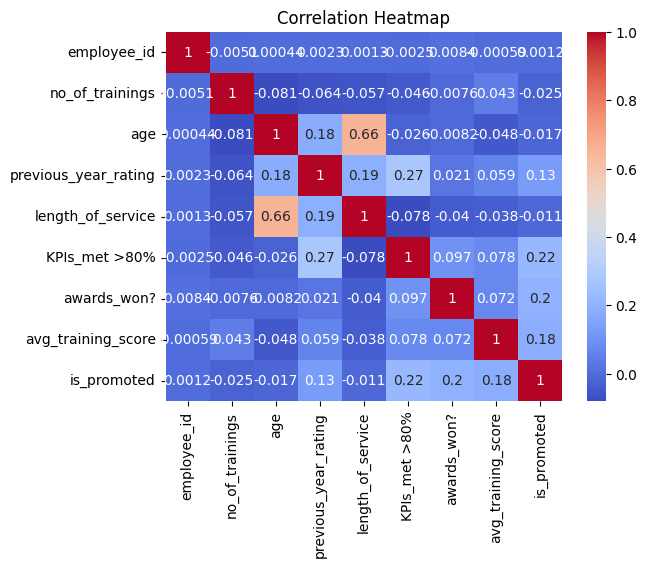

In [97]:
# Let's check the overall correlations in the dataset
numerical_columns = data.select_dtypes(include=('int64', 'float64')).columns
corr_matrix = data[numerical_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Age column correlates with the length of service, which is logical and it make sense to keep probably only the length of service, which is more valuable for company.
Target columns correlates with the trainiing score, number of awards, KPI and the previous year rating. This columns might be the key ones.

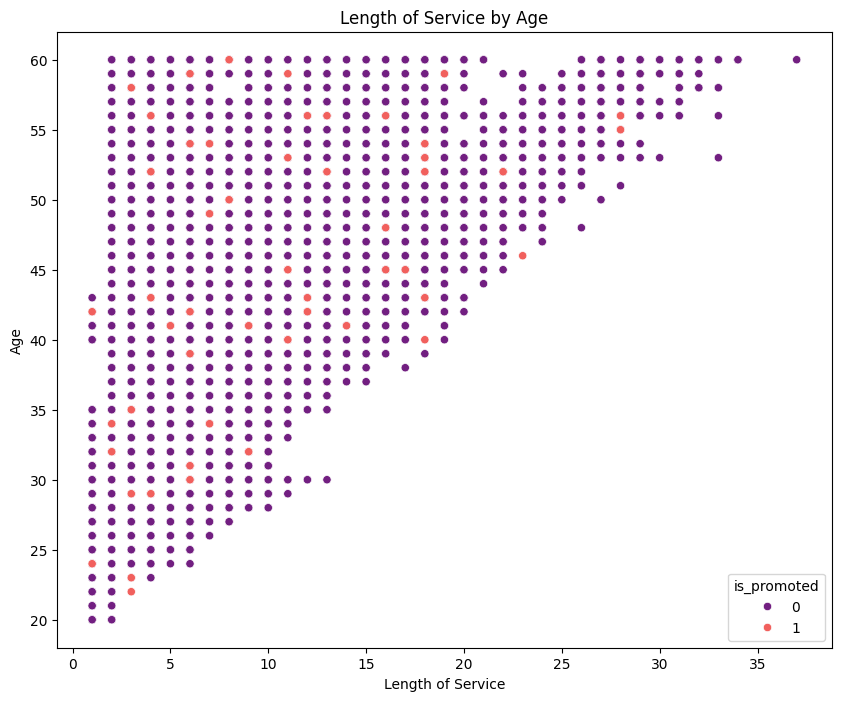

In [98]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='length_of_service', y='age', hue='is_promoted', palette='magma')
plt.xlabel('Length of Service')
plt.ylabel('Age')
plt.title('Length of Service by Age')
plt.show()

It is hard to say, that promotion correlates with either length of service or age.

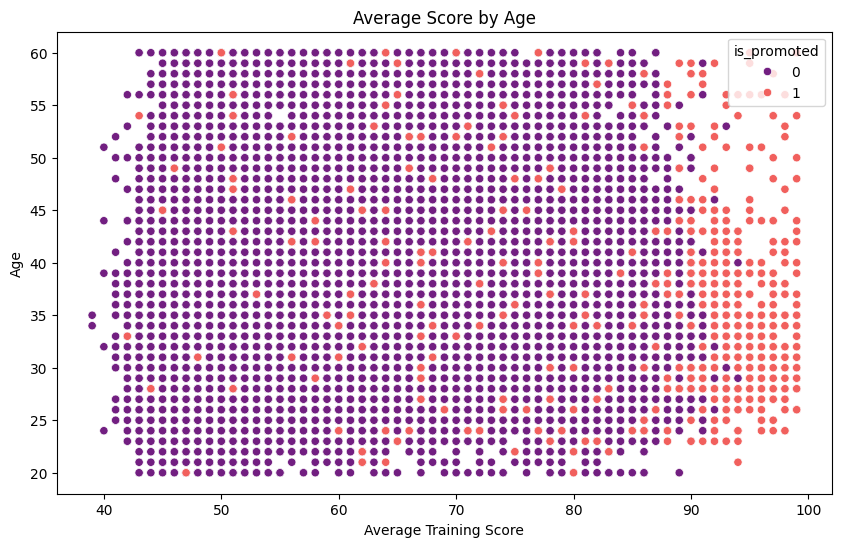

In [99]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='avg_training_score', y='age', hue='is_promoted', palette='magma')
plt.xlabel('Average Training Score')
plt.ylabel('Age')
plt.title('Average Score by Age')
plt.show()

As we can see there is a high correlation between training scores and the promotion.

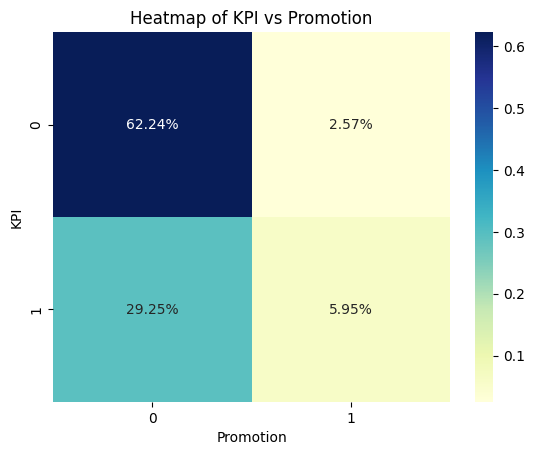

In [100]:
# Create a crosstab of the two columns
crosstab_kpi = pd.crosstab(data['KPIs_met >80%'], data['is_promoted'])
normalized_crosstab_kpi = crosstab_kpi / crosstab_kpi.sum().sum()

# Plot the heatmap
sns.heatmap(normalized_crosstab_kpi, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title('Heatmap of KPI vs Promotion')
plt.xlabel('Promotion')
plt.ylabel('KPI')
plt.show()


We can see that in general higher KPI helps to get a promotion, but the correlation is not as strong as you may think.

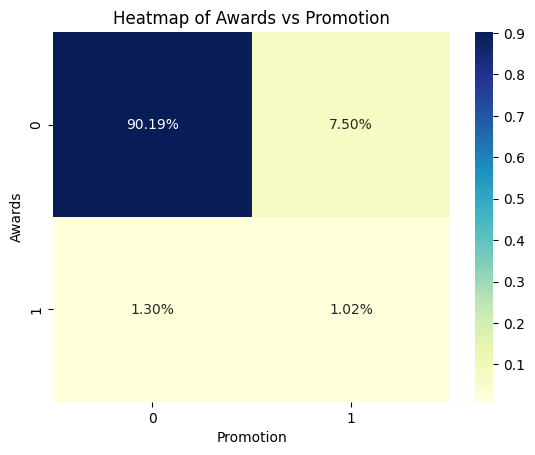

In [101]:
# Create a crosstab of the two columns
crosstab_awd = pd.crosstab(data['awards_won?'], data['is_promoted'])
normalized_crosstab_awd = crosstab_awd / crosstab_awd.sum().sum()

# Plot the heatmap
sns.heatmap(normalized_crosstab_awd, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title('Heatmap of Awards vs Promotion')
plt.xlabel('Promotion')
plt.ylabel('Awards')
plt.show()

The data is imbalanced, which makes harder to make a 100% right verdict about the correlations, but it's definitely a connection between having an award and a promoiton.

##4. Data feature preprocessing

In [102]:
# Copy the dataset to have as a checkpoint
data_train = data.copy()

In [103]:
# Check that the dataset is right
data_train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


Employee ID is an unnecessary column for model training.

In [104]:
# Drop the id column
data_train.drop(['employee_id'], axis=1, inplace=True)
data_train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [105]:
# Encode the non-numerical columns with the One Hot Encoding to use them as numerical
non_numerical_columns = ['department', 'region', 'education', 'gender', 'recruitment_channel']
ohe = OneHotEncoder(sparse=False)
encoded_features = ohe.fit_transform(data_train[non_numerical_columns])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(non_numerical_columns))
encoded_features_df.head()

,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,education_None,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [106]:
# Add the encoded non-numerical columns to the main training dataset
train = pd.concat([data_train, encoded_features_df], axis=1)
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,education_None,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [107]:
# Get rid of the unnecessary object columns
train.drop(non_numerical_columns, axis=1, inplace=True)
train.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_Finance,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,education_None,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,1,35,5.0,8,1,0,49,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,30,5.0,4,0,0,60,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,34,3.0,7,0,0,50,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2,39,1.0,10,0,0,50,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,45,3.0,2,0,0,73,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [108]:
# Split the data for the target and feature columns
X = train.drop('is_promoted', axis=1)
y = train['is_promoted']

In [109]:
# Scale data to not reevalute the feature importance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [138]:
# Assuming X and y are already defined and have the shapes (54808, 59) and (54808,) respectively
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (43846, 59)
Shape of X_test: (10962, 59)
Shape of y_train: (43846,)
Shape of y_test: (10962,)


##5. Data training

In [111]:
# Try the RF model to check the feature imortance. Use the class weight to bakance the dataset
clf = RandomForestClassifier(class_weight='balanced')
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [112]:
F1_score = f1_score(y_test, predictions)
F1_score_macro = f1_score(y_test, predictions, average='macro')
print("F1: ",F1_score)
print("F1 macro: ", F1_score_macro)

F1:  0.42354865085854454
F1 macro:  0.6947461625385907


Because of the imbalanced data it is more reasonable to adjust the f1 score with the macro parameter

In [113]:
feature_names = X.columns

In [114]:
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df = feature_imp_df[feature_imp_df['Gini Importance'] >= 0.01]
print(feature_imp_df)

                         Feature  Gini Importance
6             avg_training_score         0.227213
4                  KPIs_met >80%         0.143659
1                            age         0.104057
2           previous_year_rating         0.086277
3              length_of_service         0.080445
5                    awards_won?         0.031795
14  department_Sales & Marketing         0.025552
0                no_of_trainings         0.022449
11         department_Operations         0.015104
58  recruitment_channel_sourcing         0.014796
56     recruitment_channel_other         0.014681
27               region_region_2         0.012571
54                      gender_f         0.011628
12        department_Procurement         0.011572
55                      gender_m         0.011448
30              region_region_22         0.010992


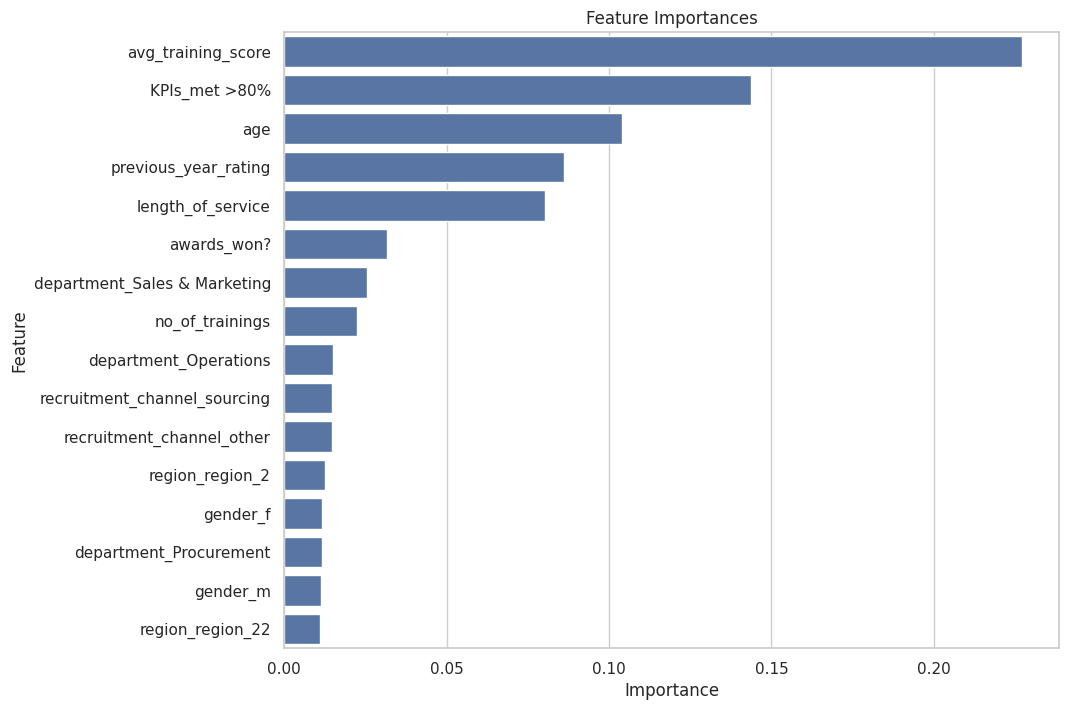

In [115]:
# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Gini Importance', y='Feature', data=feature_imp_df)

# Add labels and title
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()

In [116]:
# Make a list of different Classification models to check which one has the best performance
scoring = make_scorer(f1_score, average='macro')
models=[]
models.append(('LR', LogisticRegression(class_weight='balanced')))
models.append(('CART', DecisionTreeClassifier(class_weight='balanced')))
models.append(('RF', RandomForestClassifier(class_weight='balanced')))
models.append(('ET', ExtraTreesClassifier(class_weight='balanced')))
models.append(('GBM', GradientBoostingClassifier()))  # Gradient Boosting doesn't support class_weight
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(class_weight='balanced', max_iter=10000)))
models.append(('NB', GaussianNB()))
models.append(('AB', AdaBoostClassifier()))
models.append(('XGB', xgb.XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))))
models.append(('LGBM', lgb.LGBMClassifier(class_weight='balanced')))
models.append(('CatBoost', CatBoostClassifier(auto_class_weights='Balanced', verbose=0)))

In [117]:
# Use the cross-validation loop to make a better result
# As a scoring parameter F1-Score is used
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.615721 (0.007678)
CART: 0.683933 (0.011940)
RF: 0.702244 (0.016208)
ET: 0.669729 (0.015610)
GBM: 0.717614 (0.024185)
KNN: 0.564134 (0.010344)
SVM: 0.514722 (0.007707)
NB: 0.243654 (0.008362)
AB: 0.622352 (0.014730)
XGB: 0.656815 (0.007934)
[LightGBM] [Info] Number of positive: 3418, number of negative: 36043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 39461, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3404, number of negative: 36057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022757 seconds.
You can set `force_row_w

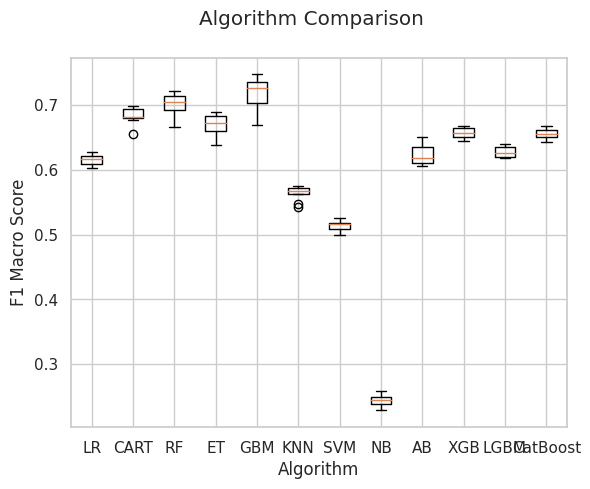

In [118]:
# compare algorithms visually
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('F1 Macro Score')
plt.xlabel('Algorithm')
plt.show()

The best result is from Gradient Boosting. So, this model will be used as the main one.

In [ ]:
##### Gradient Boosting ########
# We need to retest with sample_weights
# Calculate class frequencies
class_counts = Counter(y_train)

# Compute class weights (inverse of frequencies)
total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
# Assign sample weights based on class weights
sample_weights = np.array([class_weights[cls] for cls in y_train])

#Instantiate the model
model_gbm = GradientBoostingClassifier()
model_gbm.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model_gbm.predict(X_test)
print(f1_score(y_test, predictions, average='macro'))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.5841565676049929
[[6940 3114]
 [  44  864]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     10054
           1       0.22      0.95      0.35       908

    accuracy                           0.71     10962
   macro avg       0.61      0.82      0.58     10962
weighted avg       0.93      0.71      0.78     10962



In [ ]:
# Check the results with one without sample_weights
model_gbm_v2 = GradientBoostingClassifier()
model_gbm_v2.fit(X_train, y_train)
predictions = model_gbm_v2.predict(X_test)
print(f1_score(y_test, predictions, average='macro'))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7134470655874199
[[10043    11]
 [  635   273]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.96      0.30      0.46       908

    accuracy                           0.94     10962
   macro avg       0.95      0.65      0.71     10962
weighted avg       0.94      0.94      0.93     10962



As we can notice with the sample_weight parameter the model better predicts the promotion values, but it makes more mistakes with the no promotion value.

The results could be probably improved. Let's try to hypertune this model.

Fitting 2 folds for each of 486 candidates, totalling 972 fits
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     10054
           1       0.32      0.67      0.43       908

    accuracy                           0.85     10962
   macro avg       0.64      0.77      0.67     10962
weighted avg       0.91      0.85      0.88     10962

[[8755 1299]
 [ 303  605]]


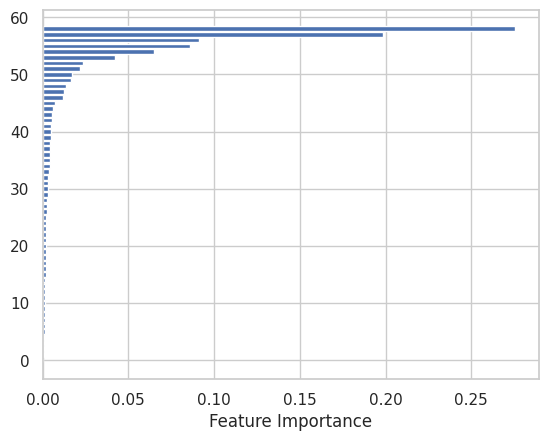

In [ ]:
### Hypertuning

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
model_gbm_hp = GradientBoostingClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_gbm_hp, param_grid=param_grid, cv=2, scoring='f1_macro', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xlabel('Feature Importance')
plt.show()

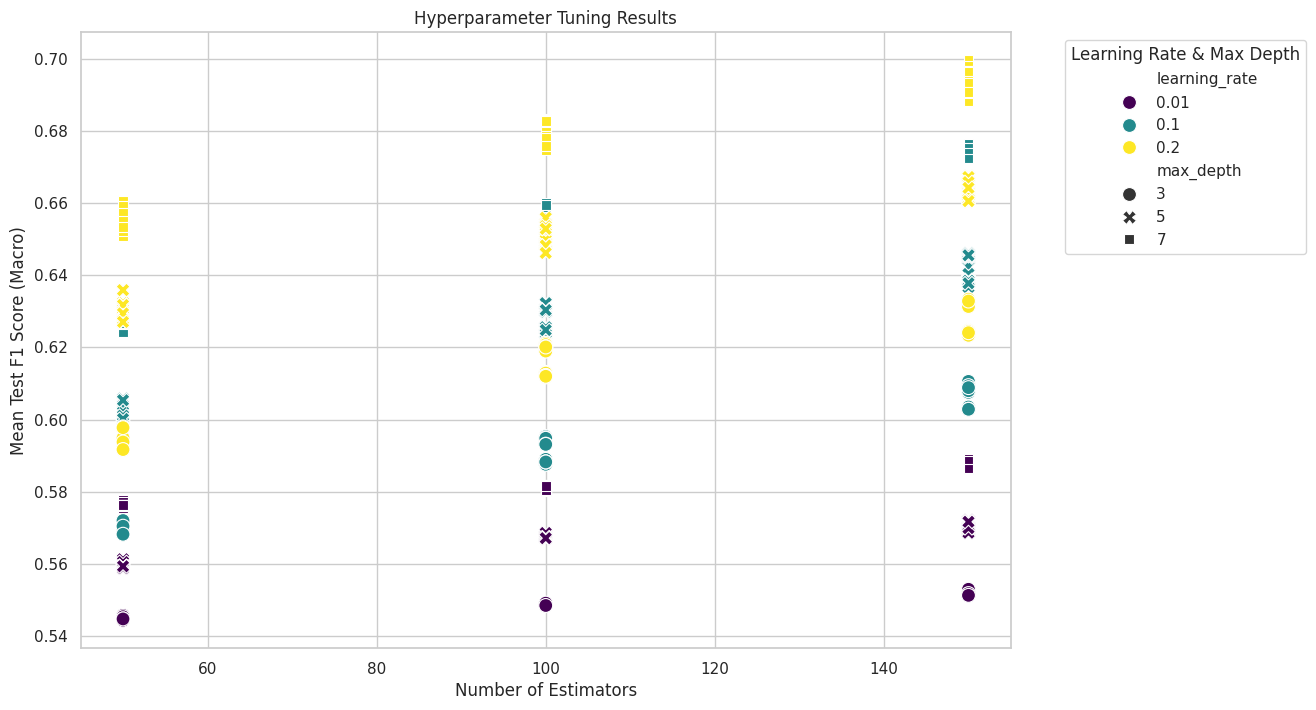

In [ ]:
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

n_estimators = [param['n_estimators'] for param in params]
learning_rates = [param['learning_rate'] for param in params]
max_depths = [param['max_depth'] for param in params]


results_df = pd.DataFrame({
    'n_estimators': n_estimators,
    'learning_rate': learning_rates,
    'max_depth': max_depths,
    'mean_test_score': mean_test_scores
})

plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df, x='n_estimators', y='mean_test_score', hue='learning_rate', style='max_depth', palette='viridis', s=100)
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test F1 Score (Macro)')
plt.legend(title='Learning Rate & Max Depth', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

It seems to be better results with bigger number of the estimators, more max_depth and learning rate around 0.2

In [ ]:
#Instantiate the model
model_gbm_v3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=10)
model_gbm_v3.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model_gbm_v3.predict(X_test)
print(f1_score(y_test, predictions, average='macro'))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7162648555489401
[[9710  344]
 [ 518  390]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10054
           1       0.53      0.43      0.48       908

    accuracy                           0.92     10962
   macro avg       0.74      0.70      0.72     10962
weighted avg       0.91      0.92      0.92     10962



In [122]:
model_xgb = xgb.XGBClassifier(booster='dart', scale_pos_weight=3, eta=0.1, n_estimators=150, max_delta_step=1)
model_xgb.fit(X_train, y_train)
predictions = model_xgb.predict(X_test)
print(f1_score(y_test, predictions, average='macro'))

0.7318928907948622


As an Experiment let's try Voting Classifier, with the GBM, RF and XGB as they had the best results.

In [139]:
clf1 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=10)
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = xgb.XGBClassifier(booster='dart', scale_pos_weight=3, eta=0.1, n_estimators=150, max_delta_step=1)


# Initialize Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('gbm', clf1),
    ('rf', clf2),
    ('xgb', clf3)
], voting='hard')  # 'hard' for majority voting, 'soft' for weighted average probabilities

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)



In [141]:
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10054
           1       0.80      0.36      0.49       908

    accuracy                           0.94     10962
   macro avg       0.87      0.67      0.73     10962
weighted avg       0.93      0.94      0.93     10962

[[9971   83]
 [ 583  325]]
0.730801713030263


As an option it could help to reduce the noise with the number of features.
Let's try this and train one more model.

In [40]:
# Try to reduce number of columns in order to minimize the noise
X_cut = X[['avg_training_score', 'KPIs_met >80%', 'length_of_service', 'previous_year_rating', 'awards_won?', 'no_of_trainings']]
X_cut_scaler = scaler.fit_transform(X_cut)

In [43]:
X_cut_train, X_cut_test, y_cut_train, y_cut_test = train_test_split(X_cut_scaler, y, test_size=0.2, random_state=42)

In [44]:
# Calculate class frequencies
class_counts = Counter(y_cut_train)

# Compute class weights (inverse of frequencies)
total_samples = len(y_cut_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
# Assign sample weights based on class weights
sample_weights = np.array([class_weights[cls] for cls in y_cut_train])

#Instantiate the model
model_gbm_v4 = GradientBoostingClassifier()
model_gbm_v4.fit(X_cut_train, y_cut_train, sample_weight=sample_weights)
predictions = model_gbm_v4.predict(X_cut_test)
print(f1_score(y_cut_test, predictions, average='macro'))
print(confusion_matrix(y_cut_test, predictions))
print(classification_report(y_cut_test, predictions))

0.5556957491119994
[[6736 3318]
 [ 119  789]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     10054
           1       0.19      0.87      0.31       908

    accuracy                           0.69     10962
   macro avg       0.59      0.77      0.56     10962
weighted avg       0.92      0.69      0.76     10962



The scoring metric is worse, so we will use all features for testing.

##6. Test prediction

In [45]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [46]:
data_test = test.copy()
data_test['previous_year_rating'] = data_test['previous_year_rating'].fillna(0)
data_test['education'] = data_test['education'].fillna('None')
data_test.drop(['employee_id'], axis=1, inplace=True)
data_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Technology,region_26,Bachelor's,m,sourcing,1,24,0.0,1,1,0,77
1,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [47]:
data_test.isnull().sum()

,0
department,0
region,0
education,0
gender,0
recruitment_channel,0
no_of_trainings,0
age,0
previous_year_rating,0
length_of_service,0
KPIs_met >80%,0


In [142]:
non_numerical_columns = ['department', 'region', 'education', 'gender', 'recruitment_channel']
encoded_features_test = ohe.fit_transform(data_test[non_numerical_columns])
encoded_features_df_test = pd.DataFrame(encoded_features_test, columns=ohe.get_feature_names_out(non_numerical_columns))
test_df = pd.concat([data_test, encoded_features_df_test], axis=1)
test_df.drop(non_numerical_columns, axis=1, inplace=True)
X_val = scaler.fit_transform(test_df)


In [51]:
test_predictions = model_gbm_v4.predict(X_val)

In [128]:
test_predictions_xgb = model_xgb.predict(X_val)

In [143]:
test_predictions_voting = voting_clf.predict(X_val)

In [ ]:
type(test_predictions)

numpy.ndarray

In [129]:
is_imported = pd.DataFrame(test_predictions, columns=['is_promoted'])
submission = pd.concat([test['employee_id'], is_imported], axis=1)
submission.head()

,employee_id,is_promoted
0,8724,1
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [130]:
is_imported = pd.DataFrame(test_predictions_xgb, columns=['is_promoted'])
submission = pd.concat([test['employee_id'], is_imported], axis=1)
submission.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [144]:
is_imported = pd.DataFrame(test_predictions_voting, columns=['is_promoted'])
submission = pd.concat([test['employee_id'], is_imported], axis=1)

In [145]:
submission.to_csv('submission_v4.csv', index=False)

## After the submission the accuracy score is around 47%, which is pretty solid result for the first attempt. Ths result could be improved in the future by using another models and tuning the parameters.